In [1]:
import torch
import random
import numpy as np
from torch.nn.init import normal_
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from skimage.io import imread
from tqdm.notebook import tqdm

from torch.nn import Linear, Conv2d, ConvTranspose2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [2]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = ('drive/My Drive/Warwick_dataset_aug/')

Mounted at /content/drive


In [3]:
input_height = 512
input_width = input_height

in_channels = 3
unit_conv = 16
out_channels = 1
kernel_size = 3
padding = 1
stride = 1

In [4]:
class Net(nn.Module):
    def __init__(self,
                 input_height,
                 input_width,
                 in_channels,
                 unit_conv,
                 kernel_size,
                 out_channels,
                 padding):
        super(Net, self).__init__()

        # channles/filters in, out
        # 3, 64
        self.conv_down_1 = Conv2d(in_channels=in_channels,
                                  out_channels=unit_conv,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)
        # 64, 64
        self.conv_down_2 = Conv2d(in_channels=unit_conv,
                                  out_channels=unit_conv,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)

        # maxpool
        # 64, 128
        self.conv_down_3 = Conv2d(in_channels=unit_conv, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)
        # 64, 128
        self.conv_down_4 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)
        # maxpool
        # 128, 256
        self.conv_down_5 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)
        # 256, 256
        self.conv_down_6 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)
        # maxpool
        # 256, 512
        self.conv_down_7 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)
        # 512, 512
        self.conv_down_8 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)
        # maxpool
        # 512, 1024
        self.conv_down_9 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 16, kernel_size=kernel_size, stride=stride, padding=padding)
        # 1024, 1024
        self.conv_down_10 = Conv2d(in_channels=unit_conv * 16, out_channels=unit_conv * 16, kernel_size=kernel_size, stride=stride, padding=padding)

        # Reverse from here:

        # introducing the upconvolution aka transpose convolution
        # tranpose_conv_parameters
        # ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size = 4, stride = 2, padding = 1)
        kernal_size_tp = 2
        stride_tp = 2
        paddig_tp = 0

        # transpose-conv
        # 1024, 512
        self.conv_tp_11 = ConvTranspose2d(in_channels=unit_conv * 16,
                                          out_channels=unit_conv * 8,
                                          kernel_size=kernal_size_tp,
                                          stride=stride_tp,
                                          padding=paddig_tp)

        # copy back up to 1024 channeles
        # 1024, 512
        self.conv_up_12 = Conv2d(in_channels=unit_conv * 16, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)
        # 512, 512
        self.conv_up_13 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)

        # transpose-conv
        # 512, 256
        self.conv_tp_14 = ConvTranspose2d(in_channels=unit_conv * 8, out_channels=unit_conv * 4, kernel_size=kernal_size_tp, stride=stride_tp, padding=paddig_tp)
        # copy back up to 512 channeles
        # 512, 256
        self.conv_up_15 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)
        # 256, 256
        self.conv_up_16 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)

        # transpose-conv
        # 256, 128
        self.conv_tp_17 = ConvTranspose2d(in_channels=unit_conv * 4, out_channels=unit_conv * 2, kernel_size=kernal_size_tp, stride=stride_tp, padding=paddig_tp)
        # copy back up to 256 channels
        # 256, 128
        self.conv_up_18 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)
        # 128, 128
        self.conv_up_19 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)

        # transpose-conv
        # 128, 64
        self.conv_tp_20 = ConvTranspose2d(in_channels=unit_conv * 2, out_channels=unit_conv, kernel_size=kernal_size_tp, stride=stride_tp, padding=paddig_tp)

        # copy back up to 128 channels
        # 128, 64
        self.conv_up_21 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv, kernel_size=kernel_size, stride=stride, padding=padding)
        # 64, 64
        self.conv_up_22 = Conv2d(in_channels=unit_conv, out_channels=unit_conv, kernel_size=kernel_size, stride=stride, padding=padding)

        # outlayer
        # 64, 1
        self.conv_final_23 = Conv2d(in_channels=unit_conv, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        # init the weights according to how it is explained in the paper
        normal_(self.conv_down_1.weight, 0, np.sqrt(2/(9*in_channels)))
        normal_(self.conv_down_2.weight, 0, np.sqrt(2/(9*unit_conv)))
        normal_(self.conv_down_3.weight, 0, np.sqrt(2/(9*unit_conv)))
        normal_(self.conv_down_4.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_down_5.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_down_6.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_down_7.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_down_8.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_down_9.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_down_10.weight, 0, np.sqrt(2/(9*unit_conv*16)))

        normal_(self.conv_tp_11.weight, 0, np.sqrt(2/(9*unit_conv*16)))
        normal_(self.conv_up_12.weight, 0, np.sqrt(2/(9*unit_conv*16)))
        normal_(self.conv_up_13.weight, 0, np.sqrt(2/(9*unit_conv*8)))

        normal_(self.conv_tp_14.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_up_15.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_up_16.weight, 0, np.sqrt(2/(9*unit_conv*4)))

        normal_(self.conv_tp_17.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_up_18.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_up_19.weight, 0, np.sqrt(2/(9*unit_conv*2)))

        normal_(self.conv_tp_20.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_up_21.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_up_22.weight, 0, np.sqrt(2/(9*unit_conv)))

        normal_(self.conv_final_23.weight, 0, np.sqrt(2/(9*unit_conv)))


    def forward(self, x):  # x.size() = [batch, channel, height, width]

        x1 = relu(self.conv_down_1(x))
        x2 = relu(self.conv_down_2(x1))
        x2mp = F.max_pool2d(x2, 2)

        x3 = relu(self.conv_down_3(x2mp))
        x4 = relu(self.conv_down_4(x3))
        x4mp = F.max_pool2d(x4, 2)

        x5 = relu(self.conv_down_5(x4mp))
        x6 = relu(self.conv_down_6(x5))
        x6mp = F.max_pool2d(x6, 2)

        x7 = relu(self.conv_down_7(x6mp))
        x8 = relu(self.conv_down_8(x7))
        x8mp = F.max_pool2d(x8, 2)

        x9 = relu(self.conv_down_9(x8mp))
        x10 = relu(self.conv_down_10(x9))

        # tranpose conv
        x11 = self.conv_tp_11(x10)
        x11c = torch.cat((x8, x11), 1)

        x12 = relu(self.conv_up_12(x11c))
        x13 = relu(self.conv_up_13(x12))

        x14 = self.conv_tp_14(x13)
        x14c = torch.cat((x6, x14), 1)

        x15 = relu(self.conv_up_15(x14c))
        x16 = relu(self.conv_up_16(x15))

        x17 = self.conv_tp_17(x16)
        x17c = torch.cat((x4, x17), 1)

        x18 = relu(self.conv_up_18(x17c))
        x19 = relu(self.conv_up_19(x18))

        x20 = self.conv_tp_20(x19)
        x20c = torch.cat((x2, x20), 1)

        x21 = relu(self.conv_up_21(x20c))
        x22 = relu(self.conv_up_22(x21))

        x23 = torch.sigmoid(self.conv_final_23(x22))
        return x23

In [5]:
# initiate and print the network
#try with a forward parse in a dummy tensor
channels = 3
w,h = 512, 512
x = np.random.normal(0,1, (1, channels, w, h)).astype('float32')
x = Variable(torch.from_numpy(x)).cuda()

unet = Net(input_height, input_width, in_channels, unit_conv, kernel_size, out_channels, padding)
unet.cuda()
out = unet(x)
print(out.size())



torch.Size([1, 1, 512, 512])


# Dataloader:

#### connect to drive:

In [6]:
# connect to Drive:
import os
drive_path = 'drive/My Drive/Warwick_dataset_pad/'
files = os.listdir(drive_path)
len(files)
#drive_path = 'drive/My Drive/Deep Learning - P9 - Cell Segmentation/Warwick_dataset_pad/'


330

In [7]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = 'drive/My Drive/Warwick_dataset_aug/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sorted(IDs_train)

#### Calculate means:

In [9]:
# calculate means and standard deviations: 
#imagesA = [drive_path+'testA_{}'.format(i) for i in range(1,61)]
#imagesB = [drive_path+'testB_{}'.format(i) for i in range(1,21)]
#imagesC = [drive_path+'train_{}'.format(i) for i in range(1,86)]
#IDs_train = imagesA+imagesC
#IDs_test = imagesB

train_dir = 'drive/My Drive/Warwick_dataset_aug/'
test_dir = 'drive/My Drive/Warwick_dataset_multi_zero/'
#test_dir = 'drive/My Drive/Warwick_dataset_aug/'

files = os.listdir(train_dir)
IDs_train = [file for file in files if file[:5] != "testB" and file[:5] != "testA"]

files = os.listdir(test_dir)
IDs_test = [file for file in files if file[:5] == "testB"]
IDs_test2 = [file for file in files if file[:5] == "testA"]

IDs_train = [os.path.join(train_dir, ID[:-9]) for ID in IDs_train if ID[-9:] == "_anno.bmp"]
IDs_test = [os.path.join(test_dir, ID[:-9]) for ID in IDs_test if ID[-9:] == "_anno.bmp"]
IDs_test2 = [os.path.join(test_dir, ID[:-9]) for ID in IDs_test2 if ID[-9:] == "_anno.bmp"]

# do random test and validation split
random.shuffle(IDs_train)
IDs_val = IDs_train[int(len(IDs_train)*0.9):]
IDs_train = IDs_train[:int(len(IDs_train)*0.9)]

print(len(IDs_train))
print(len(IDs_val))
print(len(IDs_test))
print(len(IDs_test2))




def means_and_stds(IDs, dir):
  meansR,meansG,meansB = [],[],[]
  stdsR,stdsG,stdsB = [],[],[]
  for ID in IDs:
    im = imread(ID+".bmp")
    meansR.append(np.mean(im[:,:,0]))
    meansG.append(np.mean(im[:,:,1]))
    meansB.append(np.mean(im[:,:,2]))
    stdsR.append(np.std(im[:,:,0]))
    stdsG.append(np.std(im[:,:,1]))
    stdsB.append(np.std(im[:,:,2]))


  meanR = np.mean(meansR)
  meanG = np.mean(meansG)
  meanB = np.mean(meansB)

  stdR = np.mean(stdsR)
  stdG = np.mean(stdsG)
  stdB = np.mean(stdsB)

  means = [meanR, meanG, meanB]
  stds = [stdR, stdG, stdB]
  return means, stds

means_train, stds_train = means_and_stds(IDs_train, train_dir)
means_val, stds_val = means_and_stds(IDs_val, train_dir)
means_test,  stds_test = means_and_stds(IDs_test, test_dir)
means_test2,  stds_test2 = means_and_stds(IDs_test2, test_dir)


print(means_train, stds_train)
print(means_val, stds_val)
print(means_test,  stds_test)
print(means_test2,  stds_test2)

459
51
20
60
[99.57604569910917, 64.75498943287303, 99.31566148645737] [99.38583069121472, 73.43279022184863, 97.3581813343505]
[94.08989281747856, 61.05150701485428, 94.299441094492] [98.94996940293137, 73.6125939462916, 97.28043104035288]
[139.6540952682495, 94.24285430908203, 138.2876214981079] [101.89631986336035, 81.70258314550047, 99.09259072764283]
[126.72630233764649, 83.31185143788656, 126.59277617136637] [98.86681294701312, 75.03164144618366, 96.6689451014254]


In [10]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, ID, means, stds):
        'Initialization'
        self.IDs = ID
        self.means = means
        self.stds = stds

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.IDs[index]
        # Load data and get label
        X_np = imread(ID+ '.bmp')
        y_np = imread(ID+ '_anno.bmp',as_gray=True)

        X_np_norm = X_np.copy()
        a = (X_np[:,:,0] - self.means[0])/self.stds[0]
        b = (X_np[:,:,1] - self.means[1])/self.stds[1]
        c = (X_np[:,:,2] - self.means[2])/self.stds[2]
        d = np.stack((a,b,c))

        y_np[y_np>0]=1      # can be removed later

        X = torch.from_numpy(d.astype('float32'))
        y = torch.from_numpy(y_np)

        return X, y, index
training_set = Dataset(IDs_train, means_train, stds_train)
test_set = Dataset(IDs_test, means_test,  stds_test)
params = {'batch_size': 2,
          'shuffle': True}
training_generator = torch.utils.data.DataLoader(training_set, **params)
test_generator = torch.utils.data.DataLoader(test_set, **params)

#### Testing dataloader:

torch.Size([2, 3, 512, 512])
torch.Size([2, 512, 512])
tensor(-0.0112)


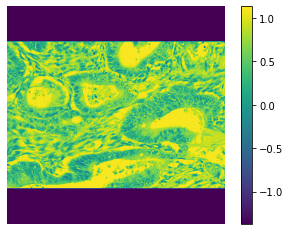

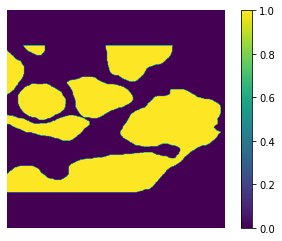

In [11]:
# test loop to load 1 batch and show results
for batch,labels,idx in test_generator:
  print(batch.shape)
  print(labels.shape)
  print(torch.mean(batch[0,0,:,:]))
  plt.figure()
  plt.imshow(batch[0,0,:,:])
  plt.colorbar()
  plt.axis('off')

  plt.figure()
  plt.imshow(labels[0,:,:])
  plt.colorbar()
  plt.axis('off')
  break

# Training:

In [12]:

def get_loss(data_loader, unet, criterion):
  
  test_loss = 0
  c = 1
  for data in (data_loader):
    inputs, labels, idx = data
    inputs = Variable(inputs).cuda()
    labels = Variable(labels).type(torch.float32).cuda()
    output = unet(inputs)
    test_loss += criterion(output.squeeze(), labels.squeeze()).detach().item()
    c += 1

  return test_loss/c

def get_loss_and_plots(test_generator, unet, criterion):
  it = iter(test_generator)
  test_loss = 0
  num_test_samples = len(it)
  for i in range(num_test_samples):
    inputs, labels, idx = next(it)
    inputs = Variable(inputs).cuda()
    labels = Variable(labels).type(torch.float32).cuda()
    output = unet(inputs)
    test_loss += criterion(output.squeeze(), labels.squeeze()).detach().item()
    if i > num_test_samples-5:        
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
      im = ax1.imshow(inputs[0,0,:,:].cpu())
      ax1.axis('off')
      ax1.set_title("input")

      im = ax2.imshow(labels[0,:,:].cpu())
      ax2.axis('off')
      ax2.set_title("label")

      output = output.cpu().detach().squeeze().numpy()
      im = ax3.imshow(output[0,:,:])
      ax3.axis('off')
      ax3.set_title("test prediction")

      fig.subplots_adjust(right=0.8)
      cbar_ax = fig.add_axes([0.85, 0.36, 0.02, 0.3])
      fig.colorbar(im, cax=cbar_ax)
      fig.show()


  return test_loss/(i+1)


In [ ]:
# training loop
batch_size = 10 # I HAVE SEEN IT RUN WITH AS MUCH AS batch_size=25
                # IF it wont run due to memory issues restart the runtime
num_epoch = 30

#make a new training or keep training
new_training = True
if new_training:
  print("A new training has started!")
  train_set = Dataset(IDs_train, means_train, stds_train)
  val_set = Dataset(IDs_val, means_val, stds_val)
  test_set = Dataset(IDs_test, means_test,  stds_test)
  test_set2 = Dataset(IDs_test2, means_test2,  stds_test2)
  
  train_params = {'batch_size': batch_size, 'shuffle': True}
  rest_params = {'batch_size': 2, 'shuffle': False}

  training_generator = torch.utils.data.DataLoader(train_set, **train_params)
  val_generator = torch.utils.data.DataLoader(val_set, **rest_params)
  test_generator = torch.utils.data.DataLoader(test_set, **rest_params)
  test2_generator = torch.utils.data.DataLoader(test_set2, **rest_params)

  unet = Net(input_height, input_width, in_channels, unit_conv, kernel_size, out_channels, padding)
  unet.cuda()

  criterion = nn.BCELoss()
  optimizer = optim.Adam(unet.parameters(), lr=0.001)
  #optimizer = optim.SGD(unet.parameters(), lr = 0.001, momentum=0.98)
  epoch_train_loss_list = []
  epoch_val_loss_list = []
  epoch_test_loss_list = []
  epoch_test2_loss_list = []
  best_avg_loss = 1
  epoch_counter = 0
  
else:
  print("Training continued")



for epoch in range(num_epoch):  # loop over the dataset multiple times
    unet.train()  
    epoch_counter += 1 #dont change this, it has to extern and not just depend on the "epoch" loop iterator
    print("\n{}. epoch".format(epoch_counter))

    epoch_loss = 0
    c = 1
    for i, data in tqdm(enumerate(training_generator, 0)):
        # get the inputs
        inputs, labels, idx = data

        # wrap them in Variable
        inputs = Variable(inputs).cuda()
        labels = Variable(labels).type(torch.float32).cuda()

        optimizer.zero_grad()
        output = unet(inputs)
        
        batch_loss = criterion(output.squeeze(), labels.squeeze())
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.detach().item()
        c += 1
        #print('[%d, %5d] batch loss: %.2f' %(epoch + 1, i + 1, batch_loss))
    
    print("average epoch train loss was: {}".format(epoch_loss/c))
    epoch_train_loss_list.append(epoch_loss/c)

    #get the test results after each epoch:
    unet.eval()
    epoch_val_loss_list.append(get_loss(val_generator, unet, criterion))
    epoch_test2_loss_list.append(get_loss(test2_generator, unet, criterion))
    epoch_test_loss_list.append(get_loss_and_plots(test_generator, unet, criterion))

    plt.figure()
    plt.plot(range(1,len(epoch_train_loss_list)+1), epoch_train_loss_list, label = "Train loss")
    plt.plot(range(1,len(epoch_val_loss_list)+1), epoch_val_loss_list, label = "Val loss")
    plt.plot(range(1,len(epoch_test_loss_list)+1), epoch_test_loss_list, label = "Test loss")
    plt.plot(range(1,len(epoch_test2_loss_list)+1), epoch_test2_loss_list, label = "Test2 loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Average epoch loss")
    plt.legend()
    plt.show()

    #saves the model if its better than the previous best based on test performance
    epoch_avg_loss = (epoch_test_loss_list[-1]*20 + epoch_test2_loss_list[-1]*60)/(60+20)
    if epoch_avg_loss < best_avg_loss:
      best_avg_loss = epoch_avg_loss
      path = 'drive/My Drive/unet.pt'
      torch.save(unet.state_dict(),path)
      print("At epoch {} a new best model was found and saved!".format(epoch))

print('Finished Training')

In [ ]:
#epoch_loss_list_copy = epoch_loss_list

test_generator
plt.plot(range(len(epoch_loss_list)), epoch_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average epoch loss")

In [ ]:

plt.figure()
plt.imshow(img_label)
plt.colorbar()
plt.axis('off')

for img in img_list:
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

In [ ]:
# test loop to load 1 batch and show results
for batch,labels,idx in training_generator:
  # print(batch.shape)
  # print(labels.shape)
  # print(torch.mean(batch[0,0,:,:]))

  plt.figure()
  plt.imshow(batch[0,0,:,:])
  plt.colorbar()
  plt.axis('off')
  plt.title('input')

  plt.figure()
  plt.imshow(labels[0,:,:])
  plt.colorbar()
  plt.axis('off')


  unet.eval()
  out = unet(Variable(batch).cuda())
  out = out.cpu().detach().squeeze().numpy()

  plt.figure()
  plt.imshow(out[0,:,:])
  plt.colorbar()
  # print(out.shape)
  # print(out)
  break